# Create a SBML Model With BioCRNpyler

In [1]:
from biocrnpyler import *
from vivarium.core.engine import pp

# TX/TL module

## BioCRNpyler makes CRN

In [2]:
G = Species("G")
T = Species("T")
P = Species("P")

ktx = 1.0
ktl = 1.0
txrxn = Reaction.from_massaction(inputs = [G], outputs = [G, T], k_forward=ktx)
tlrxn = Reaction.from_massaction(inputs = [T], outputs = [T, P], k_forward=ktl)

CRN = ChemicalReactionNetwork(
    species = [G, T, P], 
    reactions = [txrxn, tlrxn],
    initial_concentration_dict = {G:1, T:0, P:0})

print(CRN.pretty_print(show_compartment = True))

CRN.write_sbml_file("txtl.xml")

Species(N = 3) = {
G (@ 1),  T (@ 0),  P (@ 0),  
}

Reactions (2) = [
0. G --> G+T
 Kf=k_forward * G
  k_forward=1.0

1. T --> T+P
 Kf=k_forward * T
  k_forward=1.0

]


True

## Put in Vivarium-Bioscrape

In [26]:
from vivarium.core import store
from vivarium_bioscrape.processes.bioscrape import Bioscrape

txtl_parameters = {
    "sbml_file":"txtl.xml",
    "timestep": 1.0
}

#Create a Store
S = store.Store({})
bioscrape_process = Bioscrape(txtl_parameters)
S["txtl"] = bioscrape_process
S.set_value(bioscrape_process.initial_state())
print(pp(S.get_value()))

{ 'delta_species': {'G': 0.0, 'P': 0.0, 'T': 0.0},
  'globals': {'volume': 1.0},
  'rates': {'k_forward': 1.0, 'k_forward_r1': 1.0},
  'species': {'G': 1.0, 'P': 0.0, 'T': 0.0},
  'txtl': ( <vivarium_bioscrape.processes.bioscrape.Bioscrape object at 0x12ceb5a60>,
            { 'delta_species': ('delta_species',),
              'globals': ('globals',),
              'rates': ('rates',),
              'species': ('species',)})}
None


## Run the Vivarium-Bioscrape TXTL process

In [17]:
%matplotlib inline
from vivarium.core.engine import Engine

# put the store in an engine and run it
sim = Engine(store=S)
steps = 100
sim.update(steps)


Simulation ID: 353eb976-9038-11ec-8b77-acde48001122
Created: 02/17/2022 at 13:26:02
Completed in 0.040684 seconds


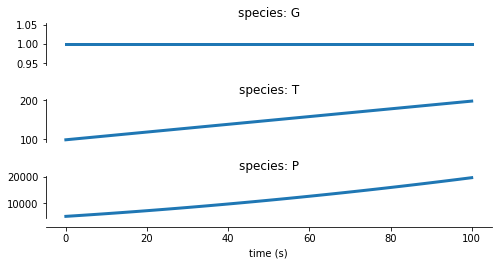

In [16]:
from vivarium.plots.simulation_output import plot_variables

# get the data
data = sim.emitter.get_timeseries()
fig = plot_variables(data, variables=[('species', 'G'),
                                ('species', 'T'),
                                ('species', 'P')])

# Biophysics

In [22]:
from vivarium.core.process import Process
import numpy as np

def gaussian(x, mean, variance):
    return np.exp(-(x - mean) ** 2 / variance)

class Salt(Process):

    defaults = {
        'mean': 5, # (Mg) this is the salt concentration for max activity
        'variance': 2,
        'max_rates': {},
    }

    def __init__(self, parameters=None):
        super().__init__(parameters)

    def ports_schema(self):
        return {
            'rates': {
                '*': {
                    '_default': 0.0,
                    '_emit': True,
                    '_updater': 'set'
                }
            },
            'salt': {
                '_default': 0.0,
                '_emit': True,
            }
        }

    def next_update(self, timestep, states):
        salt = states['salt']
        
        activity = gaussian(
            salt, self.parameters['mean'], self.parameters['variance'])
        
        return {
            'rates': {
                param_id: max_rate*activity 
                for param_id, max_rate in self.parameters['rates'].items()}
        }

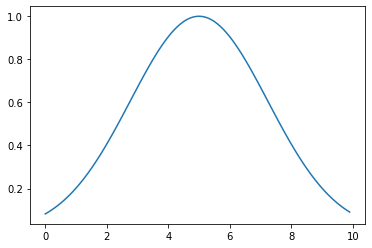

In [21]:
import pylab as plt

plt.plot(np.arange(0,10,0.1), [gaussian(x, mean=5, variance=10) for x in np.arange(0,10,0.1)])

In [37]:
#Create a Store
S2 = store.Store({})

# make bioscrape
txtl_parameters = {
    "sbml_file":"txtl.xml",
    "timestep": 1.0
}
txtl_process = Bioscrape(txtl_parameters)
S2["txtl_process"] = bioscrape_process
txtl_initial = txtl_process.initial_state()
S2.set_value(txtl_initial)

# get the rates for bioscrape_process
rates = {'k_forward': 1.0, 'k_forward_r1': 1.0}
salt_process = Salt({
    'mean': 5.,
    'variance': 1.,
    'rates': rates,
})
S2["salt_process"] = salt_process
S2["salt"] = 4.

print(pp(S2.get_value()))

{ 'delta_species': {'G': 0.0, 'P': 0.0, 'T': 0.0},
  'globals': {'volume': 1.0},
  'rates': { 'k_forward': 1.1253517471925912e-07,
             'k_forward_r1': 1.1253517471925912e-07},
  'salt': 4.0,
  'salt_process': ( <__main__.Salt object at 0x12ca6ffd0>,
                    {'rates': ('rates',), 'salt': ('salt',)}),
  'species': {'G': 1.0, 'P': 0.0, 'T': 0.0},
  'txtl_process': ( <vivarium_bioscrape.processes.bioscrape.Bioscrape object at 0x12ceb5a60>,
                    { 'delta_species': ('delta_species',),
                      'globals': ('globals',),
                      'rates': ('rates',),
                      'species': ('species',)})}
None


In [32]:
%matplotlib inline
from vivarium.core.engine import Engine

# put the store in an engine and run it
sim2 = Engine(store=S2)
steps = 100
sim2.update(steps)


Simulation ID: fee5a930-903b-11ec-8b77-acde48001122
Created: 02/17/2022 at 13:53:09
Completed in 0.054709 seconds



Simulation ID: 69dc5040-903c-11ec-8b77-acde48001122
Created: 02/17/2022 at 13:56:09
Completed in 0.040953 seconds


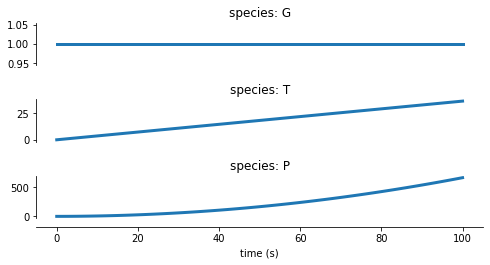

In [39]:
# put the store in an engine and run it
S2.set_value(txtl_initial)
S2["salt"] = 4.
sim2 = Engine(store=S2)
steps = 100
sim2.update(steps)

# get the data
data = sim2.emitter.get_timeseries()
fig = plot_variables(data, variables=[
    ('species', 'G'),
    ('species', 'T'),
    ('species', 'P'),
#     ('salt',),
])


Simulation ID: 79400194-903c-11ec-8b77-acde48001122
Created: 02/17/2022 at 13:56:34
Completed in 0.045998 seconds


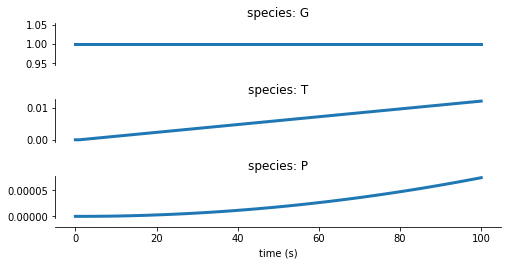

In [41]:
# put the store in an engine and run it
S2.set_value(txtl_initial)
S2["salt"] = 2
sim2 = Engine(store=S2)
steps = 100
sim2.update(steps)

# get the data
data = sim2.emitter.get_timeseries()
fig = plot_variables(data, variables=[
    ('species', 'G'),
    ('species', 'T'),
    ('species', 'P'),
#     ('salt',),
])